In [1]:
%%capture
%pip install xgboost scikit-learn matplotlib

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay, average_precision_score, accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from typing import List, Tuple

In [3]:
# Files expected to be features and one binary (0-1) valued target column. 
# Other columns must explicitly name under FEAT_EXCLUDE_COLS to be excluded as features
BASELINE_FILE: str = 'data/baseline.csv'
GRAPH_FILE: str = 'data/embedding.csv'
TARGET_COL: str = 'potentialFraudInd'
FEAT_EXCLUDE_COLS: List[str] = ['provider', 'providerId', 'avgClaimAmtReimbursed', 'inpationFraction'] + [TARGET_COL]

TEST_SPLIT_FRAC: float = 0.2
EVAL_METRIC = 'logloss'

In [4]:
def data_stats(df: pd.DataFrame):
    print(f'\tsize: {df.shape[0]} rows')
    print(f'\tpositive class ratio: {round(sum(df[TARGET_COL])/df.shape[0],4)} rows') 

def split_data(df: pd.DataFrame, verbose: bool = True) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]: 
    train_df, test_df = train_test_split(df, test_size=TEST_SPLIT_FRAC, random_state=0, stratify=df[TARGET_COL])
    if verbose:
        print('training set stats:')
        data_stats(train_df)
        print('test set stats:')
        data_stats(test_df)
    return train_df.drop(columns=FEAT_EXCLUDE_COLS), train_df[TARGET_COL], \
                test_df.drop(columns=FEAT_EXCLUDE_COLS), test_df[TARGET_COL] 

# You can tweak this....but I am starting with a pretty simple XGBoost
def generate_model(scale_pos_weight: float = 1.0):
    return  XGBClassifier(n_estimators=100, objective='binary:logistic', eval_metric = EVAL_METRIC, random_state=0,
                    max_depth=9, learning_rate=0.3, min_child_weight=20, gamma=4,
                    use_label_encoder=False, scale_pos_weight=scale_pos_weight)

def eval_precision_recall_and_acc(model, x, y, model_name: str, create_charts: bool = True) -> Tuple[float, float]:
    y_prob = model.predict_proba(x)
    y_pred = model.predict(x)
    if create_charts:
        acc_display = ConfusionMatrixDisplay.from_predictions(y, y_pred, display_labels = model.classes_,
                                       normalize='true', cmap='Greys', colorbar=False)
        acc_display =  acc_display.ax_.set_title(f'{model_name.title()} Confusion Matrix')
        
        pr_display = PrecisionRecallDisplay.from_predictions(y, y_prob[:, 1], name=model_name)
        pr_display = pr_display.ax_.set_title(f'{model_name.title()} Precision-Recall Curve')
        
        roc_display = RocCurveDisplay.from_estimator(model, x, y, name=model_name)
        roc_display = roc_display.ax_.set_title(f'{model_name} ROC Curve')
        
    return average_precision_score(y, y_prob[:, 1]), accuracy_score(y, y_pred)

## Train Baseline

In [5]:
# get data
baseline_df = pd.read_csv(BASELINE_FILE)
baseline_df

,provider,potentialFraudInd,inpationFraction,renalDiseaseIndicatorNumEnc,chronicCondAlzheimerEnc,chronicCondHeartfailureEnc,chronicCondKidneyDiseaseEnc,chronicCondCancerEnc,chronicCondObstrPulmonaryEnc,chronicCondDepressionEnc,...,chronicCondObstrPulmonaryIndEnc,chronicCondDepressionIndEnc,chronicCondDiabetesIndEnc,chronicCondIschemicHeartIndEnc,chronicCondOsteoporasisIndEnc,chronicCondrheumatoidarthritisIndEnc,chronicCondstrokeIndEnc,claimCount,avgClaimAmtReimbursed,providerId
0,PRV51001,0,0.200000,0.027972,0.052448,0.066434,0.059441,0.017483,0.034965,0.031469,...,0.034965,0.031469,0.073427,0.080420,0.020979,0.027972,0.020979,25,4185.600000,51001
1,PRV51003,1,0.469697,0.023596,0.045566,0.065094,0.052075,0.008137,0.033360,0.043938,...,0.033360,0.043938,0.081367,0.091131,0.026851,0.030919,0.009764,132,4588.409091,51003
2,PRV51004,0,0.000000,0.017464,0.048595,0.066819,0.037965,0.012149,0.031131,0.047836,...,0.031131,0.047836,0.079727,0.082005,0.037206,0.034928,0.012908,149,350.134228,51004
3,PRV51005,1,0.000000,0.024998,0.041116,0.065631,0.048934,0.015925,0.028472,0.046810,...,0.028472,0.046810,0.077116,0.086382,0.033201,0.031947,0.011968,1165,241.124464,51005
4,PRV51007,0,0.041667,0.018003,0.042553,0.065466,0.036007,0.019640,0.026187,0.047463,...,0.026187,0.047463,0.080196,0.083470,0.034370,0.036007,0.019640,72,468.194444,51007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,0,0.000000,0.016722,0.046823,0.066890,0.050167,0.013378,0.036789,0.030100,...,0.036789,0.030100,0.066890,0.093645,0.043478,0.030100,0.013378,28,380.000000,57759
5406,PRV57760,0,0.000000,0.000000,0.019481,0.071429,0.012987,0.000000,0.012987,0.045455,...,0.012987,0.045455,0.116883,0.142857,0.071429,0.006494,0.000000,22,216.818182,57760
5407,PRV57761,0,0.000000,0.028152,0.044064,0.068543,0.048960,0.017136,0.036720,0.046512,...,0.036720,0.046512,0.067319,0.075887,0.039168,0.029376,0.012240,82,225.243902,57761
5408,PRV57762,0,0.000000,0.000000,0.000000,0.000000,0.100000,0.100000,0.100000,0.000000,...,0.100000,0.000000,0.100000,0.100000,0.000000,0.000000,0.000000,1,1900.000000,57762


In [6]:
#split data
X_train_baseline, y_train_baseline, X_test_baseline, y_test_baseline = split_data(baseline_df)

training set stats:
	size: 4328 rows
	positive class ratio: 0.0936 rows
test set stats:
	size: 1082 rows
	positive class ratio: 0.0933 rows


In [7]:
#instantiate model
base_positive_class_ratio = sum(y_train_baseline==1)/sum(y_train_baseline==0)
baseline_mdl = generate_model(base_positive_class_ratio)

# fit model
baseline_mdl.fit(X_train_baseline, y_train_baseline)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=4, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=9, max_leaves=0,
              min_child_weight=20, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, ...)

## Train Graph Based Data

In [8]:
# get data
graph_df = pd.read_csv(GRAPH_FILE)
graph_df

,provider,potentialFraudInd,inpationFraction,renalDiseaseIndicatorNumEnc,chronicCondAlzheimerEnc,chronicCondHeartfailureEnc,chronicCondKidneyDiseaseEnc,chronicCondCancerEnc,chronicCondObstrPulmonaryEnc,chronicCondDepressionEnc,...,diagCodeEmb_22,diagCodeEmb_23,diagCodeEmb_24,diagCodeEmb_25,diagCodeEmb_26,diagCodeEmb_27,diagCodeEmb_28,diagCodeEmb_29,diagCodeEmb_30,diagCodeEmb_31
0,PRV51001,0,0.200000,0.027972,0.052448,0.066434,0.059441,0.017483,0.034965,0.031469,...,0.273605,0.050406,-0.283224,0.004715,-0.448540,0.099732,0.390553,-0.028287,0.822421,0.255227
1,PRV51003,1,0.469697,0.023596,0.045566,0.065094,0.052075,0.008137,0.033360,0.043938,...,0.277371,-0.014505,-0.305225,0.026654,-0.414197,0.099659,0.446014,-0.071047,0.861041,0.252484
2,PRV51004,0,0.000000,0.017464,0.048595,0.066819,0.037965,0.012149,0.031131,0.047836,...,0.261161,0.051756,-0.291583,0.019633,-0.439207,0.094085,0.433893,-0.056415,0.894695,0.303761
3,PRV51005,1,0.000000,0.024998,0.041116,0.065631,0.048934,0.015925,0.028472,0.046810,...,0.257332,0.025534,-0.295887,0.039969,-0.445222,0.089214,0.444215,-0.070490,0.875840,0.295360
4,PRV51007,0,0.041667,0.018003,0.042553,0.065466,0.036007,0.019640,0.026187,0.047463,...,0.274762,0.033359,-0.297308,0.065826,-0.414698,0.113958,0.445536,-0.033533,0.867201,0.309614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,0,0.000000,0.016722,0.046823,0.066890,0.050167,0.013378,0.036789,0.030100,...,0.230996,-0.011263,-0.341982,0.007618,-0.343226,0.082747,0.442238,-0.086445,0.804685,0.261162
5406,PRV57760,0,0.000000,0.000000,0.019481,0.071429,0.012987,0.000000,0.012987,0.045455,...,0.321729,0.002945,-0.286066,0.077699,-0.434780,0.041183,0.401512,-0.033077,0.848996,0.281134
5407,PRV57761,0,0.000000,0.028152,0.044064,0.068543,0.048960,0.017136,0.036720,0.046512,...,0.242362,0.051611,-0.336853,0.024051,-0.423022,0.096501,0.431601,-0.080111,0.875597,0.309928
5408,PRV57762,0,0.000000,0.000000,0.000000,0.000000,0.100000,0.100000,0.100000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [9]:
#split data
X_train_graph, y_train_graph, X_test_graph, y_test_graph = split_data(graph_df)

training set stats:
	size: 4328 rows
	positive class ratio: 0.0936 rows
test set stats:
	size: 1082 rows
	positive class ratio: 0.0933 rows


In [10]:
#instantiate model
graph_positive_class_ratio = sum(y_train_graph==1)/sum(y_train_graph==0)
graph_mdl = generate_model(graph_positive_class_ratio)

# fit model
graph_mdl.fit(X_train_graph, y_train_graph)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=4, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=9, max_leaves=0,
              min_child_weight=20, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, ...)

## Evaluate and Compare

(0.32808313384964805, 0.9066543438077634)

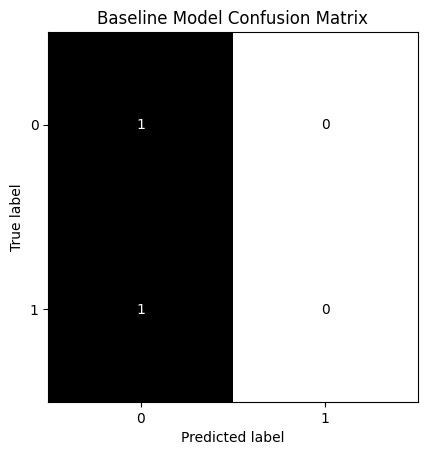

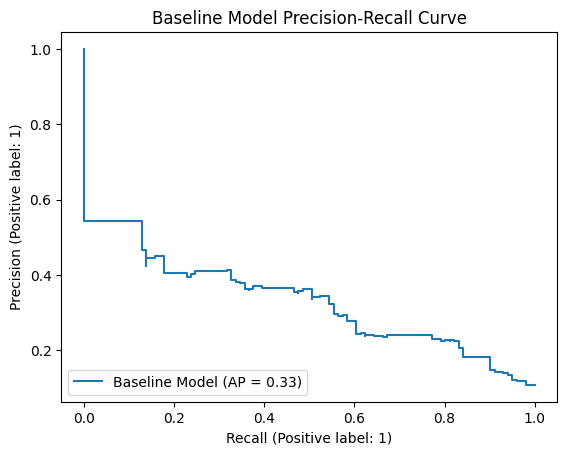

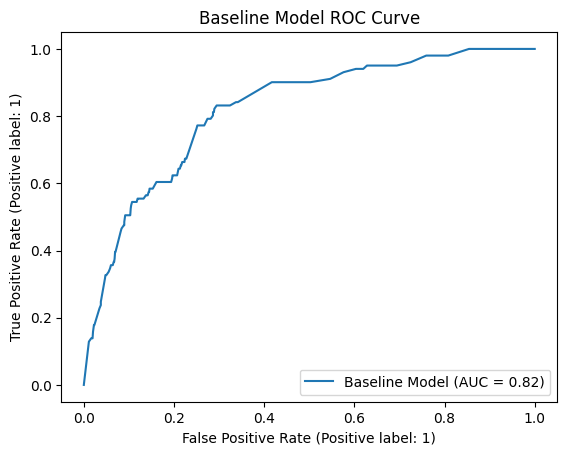

In [11]:
eval_precision_recall_and_acc(baseline_mdl, X_test_baseline, y_test_baseline, 'Baseline Model')

(0.6157183305218284, 0.9066543438077634)

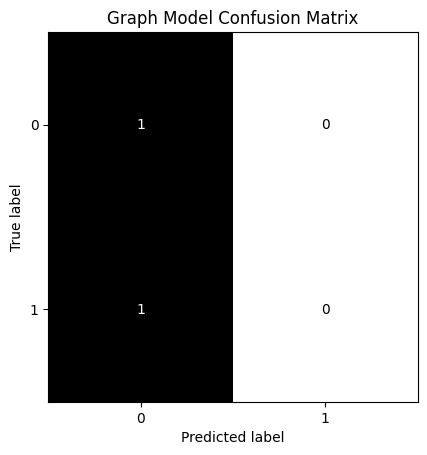

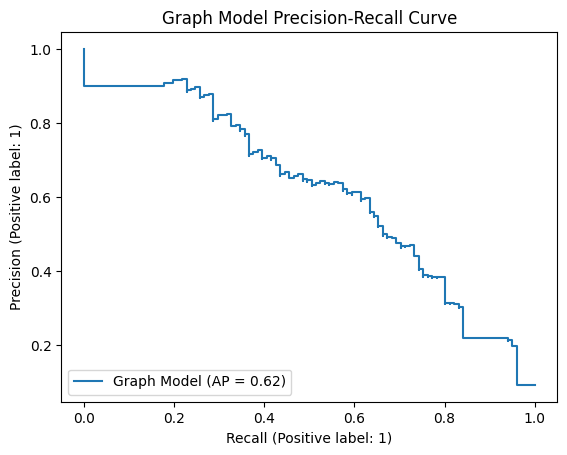

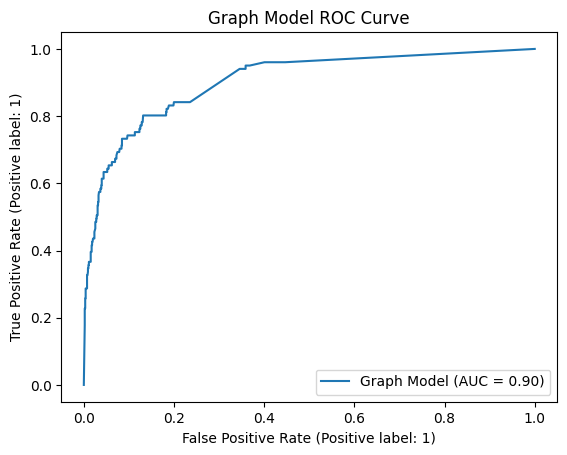

In [12]:
eval_precision_recall_and_acc(graph_mdl, X_test_graph, y_test_graph, 'Graph Model')